<a href="https://colab.research.google.com/github/Ivoryle82/Glioblastoma-Detection/blob/main/Glioblastoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SET UP COLAB

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
!pwd
!ls
# you need to set this
path_to_your_project_root_folder = 'Brain_Tumor_Dataset'
os.chdir(f'/content/drive/MyDrive/{path_to_your_project_root_folder}')
# !pwd
# !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Brain_Tumor_Dataset
negative  positive  test  test.txt  train.txt  val.txt


# Coding


Split the dataset into train and test:

Load the Dataset: First, you need to load your dataset from the specified path.  
Split the Dataset: Split your dataset into training and testing subsets using a predefined ratio, such as 80% for training and 20% for testing.  
Save the Split Data: Save the split datasets into separate folders or files for future use.  

In [ ]:
import os
import random

# Set the path to your dataset folder
dataset_folder = '/content/drive/My Drive/Brain_Tumor_Dataset'

# Set the path to the negative and positive folders
negative_folder = os.path.join(dataset_folder, 'negative')
positive_folder = os.path.join(dataset_folder, 'positive')

# Get a list of all files in the negative and positive folders
negative_files = os.listdir(negative_folder)
positive_files = os.listdir(positive_folder)

# Shuffle the filenames randomly
random.shuffle(negative_files)
random.shuffle(positive_files)

print(len(negative_files))
print(len(positive_files))
# Calculate the number of files for each set
num_train_negative = int(len(negative_files) * 0.5)
num_test_negative = int(len(negative_files) * 0.25)
num_val_negative = len(negative_files) - num_train_negative - num_test_negative

num_train_positive = int(len(positive_files) * 0.5)
num_test_positive = int(len(positive_files) * 0.25)
num_val_positive = len(positive_files) - num_train_positive - num_test_positive

# Get the filenames for each set
train_negative = negative_files[:num_train_negative]
test_negative = negative_files[num_train_negative:num_train_negative + num_test_negative]
val_negative = negative_files[num_train_negative + num_test_negative:]

train_positive = positive_files[:num_train_positive]
test_positive = positive_files[num_train_positive:num_train_positive + num_test_positive]
val_positive = positive_files[num_train_positive + num_test_positive:]

# Specify the paths for the train, test, and validation TXT files
train_txt_file_path = '/content/drive/My Drive/Brain_Tumor_Dataset/train.txt'
test_txt_file_path = '/content/drive/My Drive/Brain_Tumor_Dataset/test.txt'
val_txt_file_path = '/content/drive/My Drive/Brain_Tumor_Dataset/val.txt'

# Write the training filenames to the train TXT file
with open(train_txt_file_path, 'w') as train_txtfile:
    for file_name in train_negative:
        train_txtfile.write(file_name + ' negative\n')
    for file_name in train_positive:
        train_txtfile.write(file_name + ' positive\n')

# Write the testing filenames to the test TXT file
with open(test_txt_file_path, 'w') as test_txtfile:
    for file_name in test_negative:
        test_txtfile.write(file_name + ' negative\n')
    for file_name in test_positive:
        test_txtfile.write(file_name + ' positive\n')

# Write the validation filenames to the validation TXT file
with open(val_txt_file_path, 'w') as val_txtfile:
    for file_name in val_negative:
        val_txtfile.write(file_name + ' negative\n')
    for file_name in val_positive:
        val_txtfile.write(file_name + ' positive\n')

print("Train, test, and validation txt files created successfully!")


2000
2011
Train, test, and validation txt files created successfully!


Data Loading and Preprocessing:
load_image(image_path, label): This function loads an image from a given file path, resizes it to 256x256 pixels, normalizes pixel values, and returns the image along with its label.
create_dataset(image_paths, labels, batch_size): This function creates a TensorFlow dataset from image file paths and labels. It maps the load_image function to each image path, batches the dataset, and prefetches data for optimization.
Data Reading:
read_images_list(base_dir, filename): This function reads image file paths and corresponding labels from a text file. It appends the base directory to the image paths and categorizes the images into positive (tumor present) and negative (no tumor) classes based on the label.
Model Building:
The model consists of a series of convolutional (Conv2D) and max-pooling (MaxPooling2D) layers followed by fully connected (Dense) layers.
It starts with a convolutional layer with 8 filters, followed by max-pooling.
Then, there's another convolutional layer with 16 filters and max-pooling.
Finally, there's another convolutional layer with 16 filters before flattening the output and passing it through fully connected layers.
The output layer consists of a single neuron with sigmoid activation, suitable for binary classification tasks.
Model Training:
The model is compiled using the Adam optimizer and binary cross-entropy loss, with accuracy as the evaluation metric.
Training is performed using the fit method, where training and validation datasets are passed along with the number of steps per epoch and validation steps.
Example Usage:
The code demonstrates how to use the defined functions to load data, create datasets, build the model, and train it.
Training and testing datasets are created using the provided text files (train.txt and test.txt), containing image paths and labels.

In [ ]:
# Importing necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize image
    return image, label

def create_dataset(image_paths, labels, batch_size):
    labels = tf.constant(labels)  # Ensure labels are tensors
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def read_images_list(base_dir, filename):
    path = os.path.join(base_dir, filename)
    images_list = []
    labels_list = []
    with open(path, 'r') as file:
        lines = file.read().splitlines()
    for line in lines:
        parts = line.split()
        if len(parts) > 1:
            label_dir = 'positive' if parts[1] == 'positive' else 'negative'
            img_path = os.path.join(base_dir, label_dir, parts[0])  # Append label directory
            label = 1 if parts[1] == 'positive' else 0
            images_list.append(img_path)
            labels_list.append(label)
    return images_list, labels_list

base_dir = '../Brain_Tumor_Dataset'
train_images, train_labels = read_images_list(base_dir, 'train.txt')
test_images, test_labels = read_images_list(base_dir, 'test.txt')
val_images, val_labels = read_images_list(base_dir, 'val.txt')  # Load validation images and labels

train_dataset = create_dataset(train_images, train_labels, batch_size=20).repeat()
test_dataset = create_dataset(test_images, test_labels, batch_size=20).repeat()
val_dataset = create_dataset(val_images, val_labels, batch_size=20).repeat()  # Create validation dataset

batch_size = 32

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,      # Random rotation within 20 degrees
    width_shift_range=0.2,  # Random shift widthwise within 20% of the total width
    height_shift_range=0.2, # Random shift heightwise within 20% of the total height
    shear_range=0.2,        # Shear intensity (shear angle in radians)
    zoom_range=0.2,         # Random zoom within 20%
    horizontal_flip=True,   # Random horizontal flip
    vertical_flip=True,     # Random vertical flip
    fill_mode='nearest'     # Fill mode for points outside the boundaries
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a custom learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


# Creating a learning rate scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Creating the model with increased dropout
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.7),  # Increased dropout rate
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Adding L2 regularization
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Define a custom generator function to load images on the fly
def image_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_image_paths = image_paths[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            batch_images = []
            for image_path in batch_image_paths:
                image = tf.io.read_file(image_path)
                image = tf.image.decode_jpeg(image, channels=3)
                image = tf.image.resize(image, [256, 256])
                image = tf.cast(image, tf.float32) / 255.0
                batch_images.append(image)
            yield (np.array(batch_images), np.array(batch_labels))

# Compiling the model with a custom learning rate
initial_learning_rate = 0.001  # Initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)  # Adam optimizer with initial learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Training the model with augmented data
history = model.fit(
    image_generator(train_images, train_labels, batch_size),
    steps_per_epoch=len(train_images) // batch_size,
    epochs=40,
    validation_data=image_generator(val_images, val_labels, batch_size),
    validation_steps=len(val_images) // batch_size,
    verbose=2,
    callbacks=[lr_callback, early_stopping]
)



KeyboardInterrupt: 

**Model Accuracy Plot:**
This plot visualizes the accuracy of the model during training and validation epochs.
The x-axis represents the number of epochs, indicating the progress of training.
The y-axis represents the accuracy of the model, showing how well the model performs on the training and validation datasets.
The blue line represents the training accuracy, indicating how accurately the model predicts the training data over epochs.
The orange line represents the validation accuracy, indicating how accurately the model predicts the validation data over epochs.
Interpretation:
Ideally, both training and validation accuracy should increase over epochs, indicating that the model is learning and generalizing well.
If the training accuracy keeps increasing while the validation accuracy plateaus or decreases, it could indicate overfitting, where the model is fitting too closely to the training data and not generalizing well to unseen data.

**Model Loss Plot:**
This plot visualizes the loss (error) of the model during training and validation epochs.
The x-axis represents the number of epochs, indicating the progress of training.
The y-axis represents the loss value, showing how much error the model makes on the training and validation datasets.
The blue line represents the training loss, indicating the amount of error on the training data over epochs.
The orange line represents the validation loss, indicating the amount of error on the validation data over epochs.
Interpretation:
Ideally, both training and validation loss should decrease over epochs, indicating that the model is learning to minimize its error.
If the training loss decreases but the validation loss starts to increase or plateaus, it could indicate overfitting, where the model is fitting too closely to the training data and not generalizing well to unseen data.
If both training and validation loss remain high, it could indicate underfitting, where the model is too simple to capture the underlying patterns in the data.

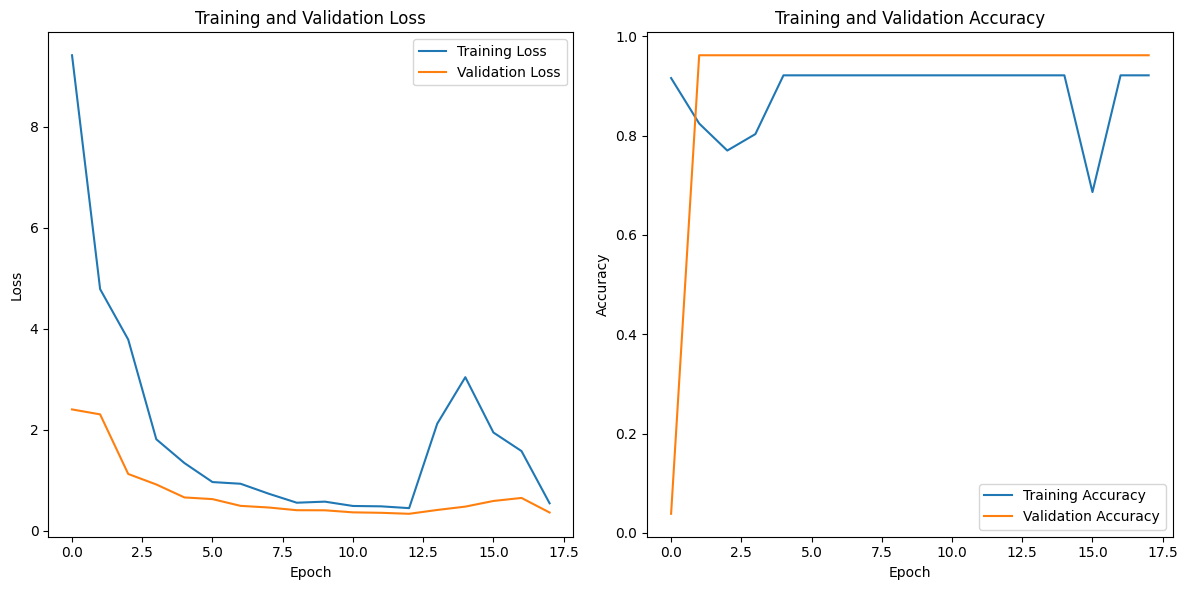

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss and accuracy from history
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Generate predictions for the test dataset
test_images, test_labels = zip(*test_dataset.unbatch().take(len(test_labels)))  # Unbatch dataset and take the necessary number of images
test_images = np.array(list(test_images))  # Convert images to numpy array
test_labels = np.array(test_labels)  # Convert labels to numpy array

# Predict probabilities and apply threshold
predictions = model.predict(test_images)
predictions = (predictions > 0.5).astype(int).flatten()  # Apply threshold and flatten


14/14 [==============================] - 2s 111ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Define label names
label_names = ['Negative', 'Positive']

# Print out each number for each square in the confusion matrix
for i in range(len(cm)):
    for j in range(len(cm[i])):
        print(f"Actual {label_names[i]}, Predicted {label_names[j]}: {cm[i][j]}")

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [542, 433]

14/14 [==============================] - 1s 48ms/step


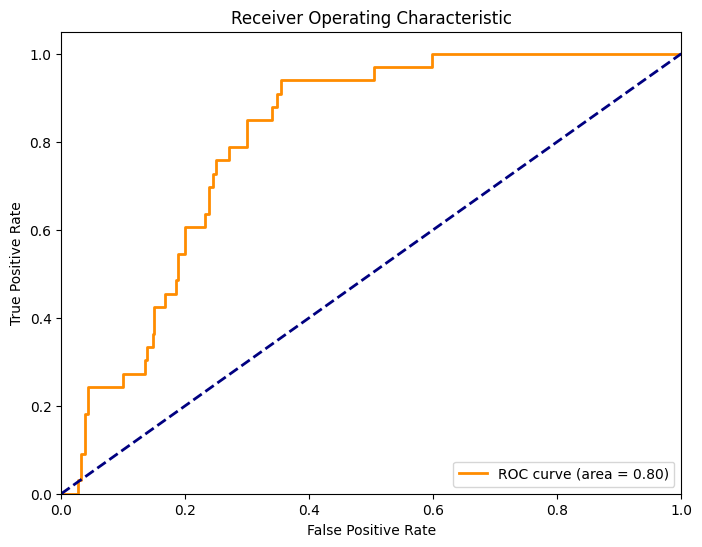

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve from test labels and predicted probabilities
fpr, tpr, thresholds = roc_curve(test_labels, model.predict(test_images))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


1/1 [==============================] - 0s 33ms/step


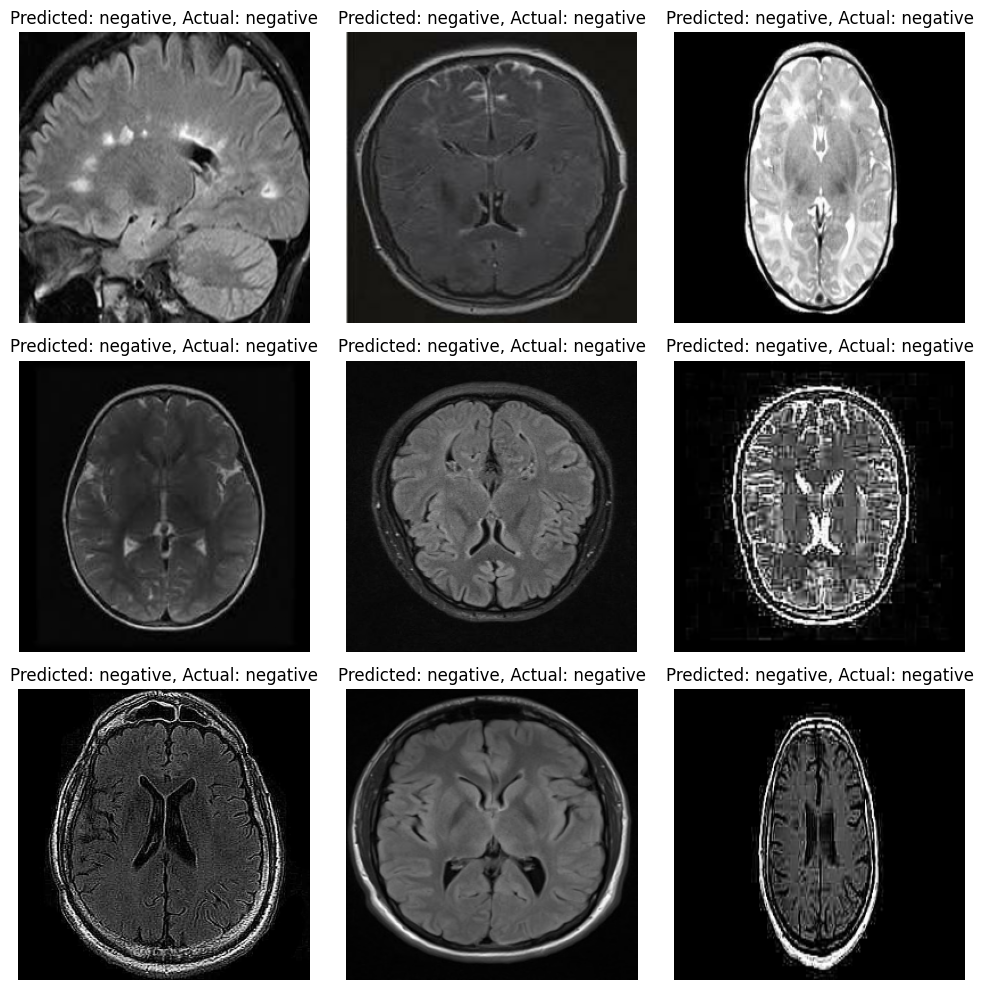

In [ ]:
# Display some image predictions
import matplotlib.pyplot as plt

def display_image_predictions(images, true_labels, preds):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        predicted_label = "positive" if preds[i] == 1 else "negative"
        true_label = "positive" if true_labels[i] == 1 else "negative"
        plt.title(f'Predicted: {predicted_label}, Actual: {true_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


sample_images, sample_labels = next(iter(test_dataset))  # Get a batch from the dataset
sample_preds = (model.predict(sample_images) > 0.5).astype(int)  # Predict and binarize
display_image_predictions(sample_images.numpy(), sample_labels.numpy(), sample_preds)
